In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def set_gnuplot_style():
    mpl.rcParams.update({

        # --- Figura ---
        "figure.figsize": (6.0, 4.0),
        "figure.dpi": 120,
        "figure.facecolor": "white",

        # --- Ejes ---
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 1.0,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "axes.grid": False,

        # --- Ticks (muy importante para look gnuplot) ---
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 6,
        "ytick.major.size": 6,
        "xtick.minor.size": 3,
        "ytick.minor.size": 3,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.minor.width": 0.8,
        "ytick.minor.width": 0.8,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "xtick.top": True,
        "ytick.right": True,

        # --- Líneas ---
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0.8,

        # --- Leyenda ---
        "legend.frameon": False,
        "legend.fontsize": 10,
        "legend.handlelength": 2.5,

        # --- Fuentes ---
        "font.family": "serif",
        "font.size": 12,

        # --- Guardado ---
        "savefig.bbox": "tight",
        "savefig.dpi": 300
    })


# SIR Density chart

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_199160/2042142756.py:1: SyntaxWarning: invalid escape sequence '\s'
  main_df = pd.read_csv('../output/stats-SIR-I=   0.30000-R=   1.00000-S=    2.dat', sep='\s+', names=['t', 'irate', 'rrate', 'idens', 'rdens'])


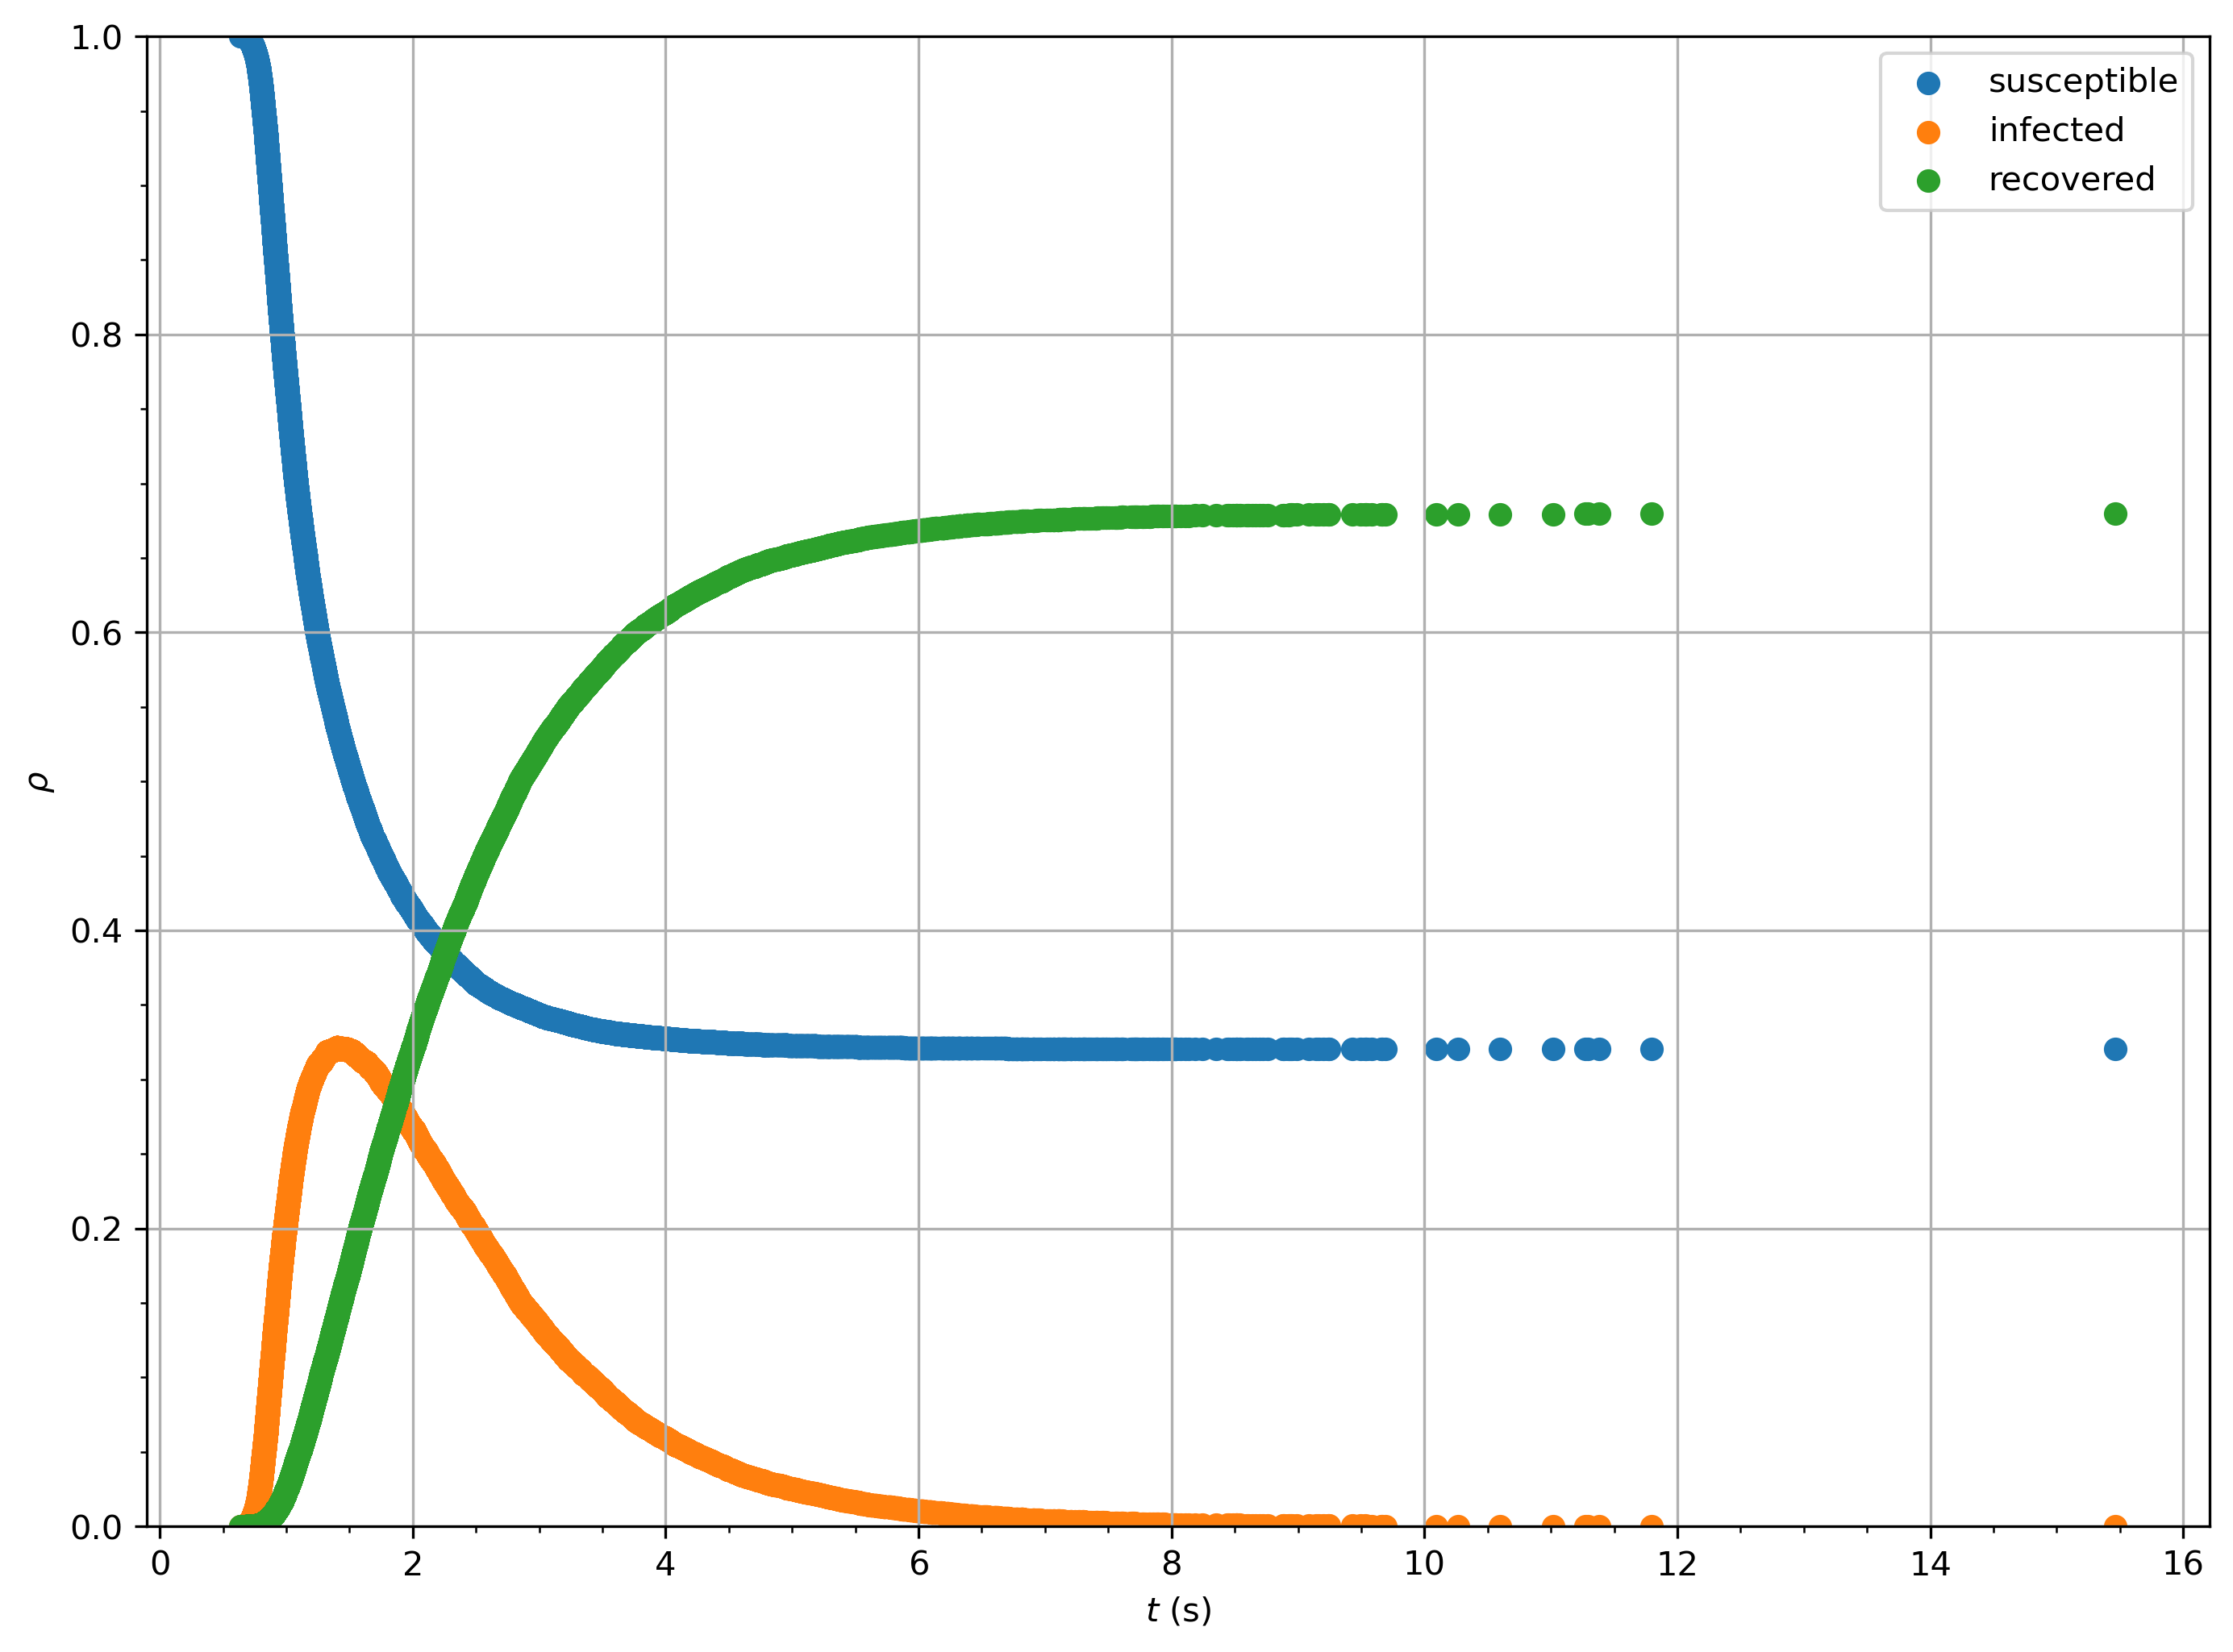

In [21]:
main_df = pd.read_csv('../output/stats-SIR-I=   0.30000-R=   1.00000-S=    2.dat', sep='\s+', names=['t', 'irate', 'rrate', 'idens', 'rdens'])
fig, ax = plt.subplots(figsize=(11, 8), dpi=300)
ax.minorticks_on()
# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.scatter(main_df['t'], 1-main_df['rdens']-main_df['idens'], marker='o', label='susceptible')
ax.scatter(main_df['t'], main_df['idens'], marker='o', label='infected')
ax.scatter(main_df['t'], main_df['rdens'], marker='o', label='recovered')
ax.legend()
ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$\rho$')
ax.grid()
plt.show()